In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/My Drive/Parking")

In [3]:
!ls


assets	 MANIFEST.in	    README.md	      setup.cfg
images	 mask_rcnn_coco.h5  requirements.txt  setup.py
LICENSE  mrcnn		    samples	      test_images


In [4]:
!pip3 install --upgrade tensorflow==1.3
!pip3 install --upgrade keras==2.0.8
!pip3 install twilio

     |████████████████████████████████| 43.6MB 96kB/s 
     |████████████████████████████████| 1.6MB 44.7MB/s 
     |████████████████████████████████| 890kB 44.1MB/s 
  Created wheel for html5lib: filename=html5lib-0.9999999-cp36-none-any.whl size=107220 sha256=24568668be2a76ba8b5f853446ab457c0a3750e67899fc6e1145d7fda7b51a55
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Found existing installation: bleach 3.2.1
    Uninstalling bleach-3.2.1:
      Successfully uninstalled bleach-3.2.1
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0
     |████████████████████████████████| 276kB 3.8MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.8 which is incompatible.
  F

In [5]:
!mkdir ak
#!rm -r ak

In [6]:
#imports

import numpy as np
import cv2
import mrcnn.config
import mrcnn.utils
from pathlib import Path
import matplotlib as pt
from mrcnn.model import MaskRCNN
from twilio.rest import Client

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:461: FutureWarning: Passing (type, 1) or 

In [7]:
class MaskRCNNConfig(mrcnn.config.Config):
    NAME = "coco_pretrained_model_config"
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1
    NUM_CLASSES = 80 + 1
    DETECTION_MIN_CONFIDENCE = 0.6

Current frame count0


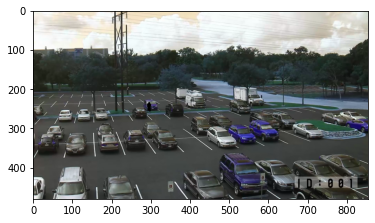

Current frame count5


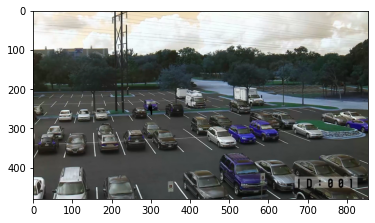

Current frame count10


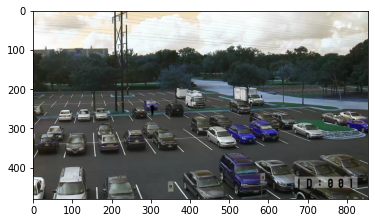

Current frame count15


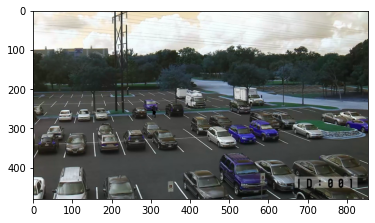

Current frame count20


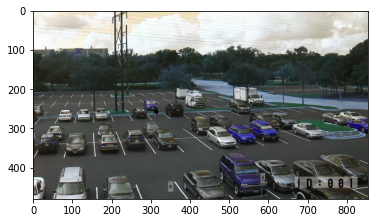

Current frame count25


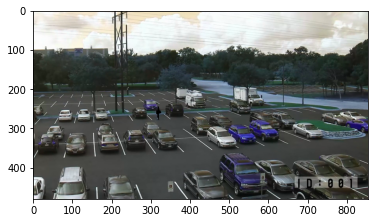

Current frame count30


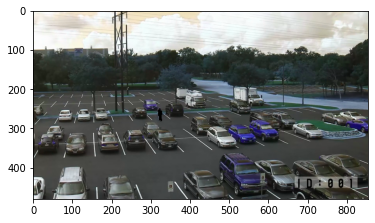

Current frame count35


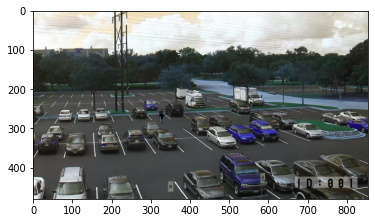

Current frame count40


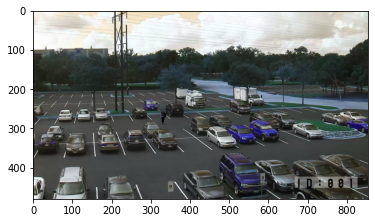

Current frame count45


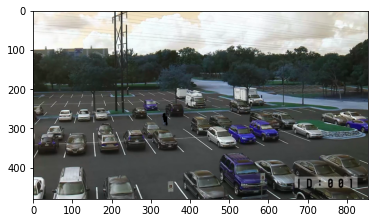

Current frame count50


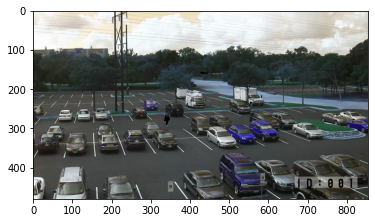

Current frame count55


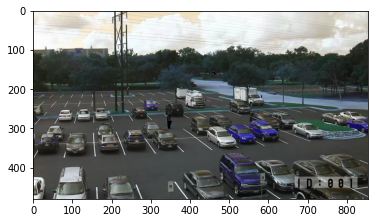

going in to mark vehicles. Frame number:   60
SENDING SMS!!!
Hope you got the message on your phone
No frame to process. Video finished


In [11]:
twilio_acc_sid = 'AC0cf0ecafd825a8c8d51af59cde8b49ff'
twilio_auth = '01b237c30c57c66dc615de8566feb892'
twilio_phone_number = '+12059841743'
twilio_destination_number = '+6285156041042'
client = Client(twilio_acc_sid, twilio_auth)

ROOT_DIR = Path(".")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
coco_model_path = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

model = MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=MaskRCNNConfig())
model.load_weights(coco_model_path, by_name=True)

Video_source = "test_images/stace_park.mp4"
video_capture = cv2.VideoCapture(Video_source)

count = 0
parked_car_boxes = None
car_boxes = None
free_space = False
sms_sent = False

# Filter to only cars
def get_car_boxes(boxes, class_ids):
    car_boxes = []

    for i, box in enumerate(boxes):
        if class_ids[i] in [3, 8, 6]:
            car_boxes.append(box)

    return np.array(car_boxes)

#our main loop
while video_capture.isOpened():
    success, frame = video_capture.read()
    
    #image = frame
    if not success:
        print("No frame to process. Video finished")
        break
        
    elif count<60:
      #create another video reader object to compare the two frames and verify the possibility of motion
      success, frame2 = video_capture.read()
      d = cv2.absdiff(frame, frame2)  
      grey = cv2.cvtColor(d, cv2.COLOR_BGR2GRAY)
      blur = cv2.GaussianBlur(grey, (1, 1), 0)
      ret, th = cv2.threshold( blur, 20, 255, cv2.THRESH_BINARY)
      
      #perform these morphological transformations to erode the car which is moving so that it is not detected by MASKRCNN. Take the eorsion levels to be high. 
      dilated = cv2.dilate(th, np.ones((10, 10), np.uint8), iterations=1 )
      eroded = cv2.erode(dilated, np.ones((10, 10), np.uint8), iterations=1 )
        
      #fill the contours for even a better morphing of the vehicle
      c, h = cv2.findContours(eroded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
      frame2 = cv2.drawContours(frame2, c, -1, (0,0,0), cv2.FILLED)

      if count % 5 == 0:
        print("Current frame count" + str(count))
        pt.pyplot.imshow(frame2)
        pt.pyplot.show()
        
      count = count + 1
      continue

    #gbr to rgb
    rgb_image = frame[:, :, ::-1]

    if parked_car_boxes is None:
        print("going in to mark vehicles. Frame number:  ", count)
        results = model.detect([rgb_image], verbose=0)
        r = results[0]
        parked_car_boxes = get_car_boxes(r['rois'], r['class_ids'])

    elif count%200 == 0 and len(parked_car_boxes) != 0:
        results = model.detect([rgb_image], verbose=0)
        r = results[0]

        # Get where cars are currently located in the frame
        car_boxes = get_car_boxes(r['rois'], r['class_ids'])

        # See how much those cars overlap with the known parking spaces
        overlaps = mrcnn.utils.compute_overlaps(parked_car_boxes, car_boxes)

        # Loop through each known parking space box
        for parking_area, overlap_areas in zip(parked_car_boxes, overlaps):

            # For this parking space, find the max amount it was covered by any
            # car that was detected in our image (doesn't really matter which car)
            max_IoU_overlap = np.max(overlap_areas)

            # Get the top-left and bottom-right coordinates of the parking area
            y1, x1, y2, x2 = parking_area

            # Check if the parking space is occupied by seeing if any car overlaps
            # it by more than 0.15 using IoU
            if max_IoU_overlap < 0.15:
                # Parking space not occupied! Draw a green box around it
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)
                # Flag that we have seen at least one open space
                free_space = True
            else:
                # Parking space is still occupied - draw a red box around it
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 1)

            # Write the IoU measurement inside the box
            font = cv2.FONT_HERSHEY_DUPLEX
            cv2.putText(frame, f"{max_IoU_overlap:0.2}", (x1 + 6, y2 - 6), font, 0.7, (255, 255, 255))

    if free_space:
          # Write SPACE AVAILABLE!! at the top of the screen
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(frame, f"SPACE AVAILABLE!", (10, 150), font, 3.0, (0, 255, 0), 2, cv2.FILLED)
          
        # If we haven't sent an SMS yet, sent it!
        if not sms_sent:
            print("SENDING SMS!!!")
            message = client.messages.create(
                body="Parking space available!!!",
                from_=twilio_phone_number,
                to=twilio_destination_number
            )
            sms_sent = True
            print("Hope you got the message on your phone")

      
    #saving each frame
    name = str(count) + ".jpg"
    name = os.path.join('./ak', name)
    cv2.imwrite(name, frame)
    count+=1
    
video_capture.release()




In [12]:
#create video including all the frames in the ak folder
import glob

images = list(glob.iglob(os.path.join('./ak', '*.*')))
images = sorted(images, key=lambda x: float(os.path.split(x)[1][:-3]))

# Get all image file paths to a list.
# Sort the images by name index.
# images = sorted(images, key=lambda x: float(os.path.split(x)[1][:-3]))

def make_video(outvid, images=None, fps=30, size=None,
               is_color=True, format="FMP4"):
    """
    Create a video from a list of images.
 
    @param      outvid      output video
    @param      images      list of images to use in the video
    @param      fps         frame per second
    @param      size        size of each frame
    @param      is_color    color
    @param      format      see http://www.fourcc.org/codecs.php
    @return                 see http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
    """
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        if not os.path.exists(image):
            raise FileNotFoundError(image)
        img = imread(image)
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    vid.release()
    return vid
  
make_video('./FinalVideo.mp4', images, fps=30)

<VideoWriter 0x7fee2baae990>